In [23]:
import os, sys
sys.path.insert(1, '../')

from importlib import reload
from tqdm import tqdm
from time import time

import numpy as np
import pandas as pd

import utils

import matplotlib
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
native_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
native_df

,sequence,measured,predicted
index,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985


In [20]:
reload(utils)
n_trial = 1000
qs = [0.25, 0.5, 0.75]
ns = np.logspace(np.log10(50), np.log10(2000), num=10, base=10).astype(int)
alpha = 0.1
use_clt = True
n_train = 5
save = True
save_fname = 'iid-clt-results-011722.csv'

y_all = native_df.measured.to_numpy()
f_all = native_df.predicted.to_numpy()

columns = ['q', 'n', 'width', 'covered', 'estimator', 'lower', 'upper']
results = []
for q_idx, q in enumerate(qs):
    for n_idx, n in enumerate(ns):
        for _ in tqdm(range(n_trial)):
            
            q_true, ci_pp, ci_cl  = utils.get_quantile_intervals(
                y_all, f_all, q, n, alpha, use_clt=True, n_train=n_train
            )
            cov_cl = (ci_cl[0] <= q_true) & (ci_cl[1] >= q_true)
            cov_pp = (ci_pp[0] <= q_true) & (ci_pp[1] >= q_true)
            results.append([q, n, ci_pp[1] - ci_pp[0], int(cov_pp), 'prediction-powered', ci_pp[0], ci_pp[1]])
            results.append([q, n, ci_cl[1] - ci_cl[0], int(cov_cl), 'classical', ci_cl[0], ci_cl[1]])
            
        df = pd.DataFrame(results, columns=columns)
        if save:
            df.to_csv(save_fname)
        
        print('n = {}, q = {}'.format(n, q))
        print('  avg. classical width: {:.2f}, avg. PP width: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].width.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].width.mean()
        ))
        print('  avg. classical cov: {:.2f}, avg. PP cov: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].covered.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].covered.mean()
        ))

100%|██████████| 1000/1000 [01:08<00:00, 14.66it/s]


n = 49, q = 0.25
  avg. classical width: 1.81, avg. PP width: 1.25
  avg. classical cov: 0.93, avg. PP cov: 0.90


100%|██████████| 1000/1000 [01:11<00:00, 14.02it/s]


n = 75, q = 0.25
  avg. classical width: 1.35, avg. PP width: 0.96
  avg. classical cov: 0.94, avg. PP cov: 0.90


100%|██████████| 1000/1000 [01:13<00:00, 13.57it/s]


n = 113, q = 0.25
  avg. classical width: 1.09, avg. PP width: 0.75
  avg. classical cov: 0.92, avg. PP cov: 0.87


100%|██████████| 1000/1000 [01:12<00:00, 13.73it/s]


n = 170, q = 0.25
  avg. classical width: 0.84, avg. PP width: 0.59
  avg. classical cov: 0.91, avg. PP cov: 0.84


100%|██████████| 1000/1000 [01:14<00:00, 13.45it/s]


n = 257, q = 0.25
  avg. classical width: 0.66, avg. PP width: 0.45
  avg. classical cov: 0.90, avg. PP cov: 0.80


100%|██████████| 1000/1000 [01:14<00:00, 13.48it/s]


n = 388, q = 0.25
  avg. classical width: 0.55, avg. PP width: 0.34
  avg. classical cov: 0.91, avg. PP cov: 0.78


100%|██████████| 1000/1000 [01:15<00:00, 13.20it/s]


n = 584, q = 0.25
  avg. classical width: 0.44, avg. PP width: 0.26
  avg. classical cov: 0.90, avg. PP cov: 0.71


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


n = 881, q = 0.25
  avg. classical width: 0.36, avg. PP width: 0.19
  avg. classical cov: 0.92, avg. PP cov: 0.69


100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]


n = 1327, q = 0.25
  avg. classical width: 0.29, avg. PP width: 0.14
  avg. classical cov: 0.92, avg. PP cov: 0.64


100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


n = 2000, q = 0.25
  avg. classical width: 0.23, avg. PP width: 0.10
  avg. classical cov: 0.91, avg. PP cov: 0.53


100%|██████████| 1000/1000 [01:06<00:00, 14.96it/s]


n = 49, q = 0.5
  avg. classical width: 3.65, avg. PP width: 2.27
  avg. classical cov: 0.93, avg. PP cov: 0.95


100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


n = 75, q = 0.5
  avg. classical width: 2.96, avg. PP width: 1.69
  avg. classical cov: 0.92, avg. PP cov: 0.94


100%|██████████| 1000/1000 [01:10<00:00, 14.23it/s]


n = 113, q = 0.5
  avg. classical width: 2.40, avg. PP width: 1.29
  avg. classical cov: 0.89, avg. PP cov: 0.91


100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


n = 170, q = 0.5
  avg. classical width: 1.91, avg. PP width: 0.97
  avg. classical cov: 0.89, avg. PP cov: 0.87


100%|██████████| 1000/1000 [01:13<00:00, 13.53it/s]


n = 257, q = 0.5
  avg. classical width: 1.58, avg. PP width: 0.76
  avg. classical cov: 0.91, avg. PP cov: 0.89


100%|██████████| 1000/1000 [01:15<00:00, 13.18it/s]


n = 388, q = 0.5
  avg. classical width: 1.30, avg. PP width: 0.60
  avg. classical cov: 0.91, avg. PP cov: 0.85


100%|██████████| 1000/1000 [01:16<00:00, 13.10it/s]


n = 584, q = 0.5
  avg. classical width: 1.03, avg. PP width: 0.46
  avg. classical cov: 0.90, avg. PP cov: 0.84


100%|██████████| 1000/1000 [01:18<00:00, 12.81it/s]


n = 881, q = 0.5
  avg. classical width: 0.84, avg. PP width: 0.36
  avg. classical cov: 0.90, avg. PP cov: 0.79


100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


n = 1327, q = 0.5
  avg. classical width: 0.69, avg. PP width: 0.28
  avg. classical cov: 0.91, avg. PP cov: 0.78


100%|██████████| 1000/1000 [01:24<00:00, 11.86it/s]


n = 2000, q = 0.5
  avg. classical width: 0.56, avg. PP width: 0.21
  avg. classical cov: 0.92, avg. PP cov: 0.75


100%|██████████| 1000/1000 [01:07<00:00, 14.80it/s]


n = 49, q = 0.75
  avg. classical width: 4.07, avg. PP width: 2.67
  avg. classical cov: 0.90, avg. PP cov: 0.93


100%|██████████| 1000/1000 [01:09<00:00, 14.41it/s]


n = 75, q = 0.75
  avg. classical width: 3.42, avg. PP width: 1.98
  avg. classical cov: 0.93, avg. PP cov: 0.93


100%|██████████| 1000/1000 [01:11<00:00, 14.05it/s]


n = 113, q = 0.75
  avg. classical width: 2.75, avg. PP width: 1.51
  avg. classical cov: 0.92, avg. PP cov: 0.92


100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


n = 170, q = 0.75
  avg. classical width: 2.18, avg. PP width: 1.20
  avg. classical cov: 0.90, avg. PP cov: 0.91


100%|██████████| 1000/1000 [01:14<00:00, 13.36it/s]


n = 257, q = 0.75
  avg. classical width: 1.74, avg. PP width: 0.91
  avg. classical cov: 0.90, avg. PP cov: 0.90


100%|██████████| 1000/1000 [01:16<00:00, 13.07it/s]


n = 388, q = 0.75
  avg. classical width: 1.43, avg. PP width: 0.71
  avg. classical cov: 0.91, avg. PP cov: 0.86


100%|██████████| 1000/1000 [01:18<00:00, 12.79it/s]


n = 584, q = 0.75
  avg. classical width: 1.14, avg. PP width: 0.54
  avg. classical cov: 0.91, avg. PP cov: 0.85


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


n = 881, q = 0.75
  avg. classical width: 0.93, avg. PP width: 0.44
  avg. classical cov: 0.92, avg. PP cov: 0.84


100%|██████████| 1000/1000 [01:23<00:00, 11.97it/s]


n = 1327, q = 0.75
  avg. classical width: 0.76, avg. PP width: 0.34
  avg. classical cov: 0.90, avg. PP cov: 0.81


100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


n = 2000, q = 0.75
  avg. classical width: 0.61, avg. PP width: 0.27
  avg. classical cov: 0.91, avg. PP cov: 0.81


## plot results

In [21]:
df = pd.read_csv('iid-clt-results-011722.csv', index_col=0)
df

,q,n,width,covered,estimator,lower,upper
0,0.25,49,2.400000,1,prediction-powered,2.382055,4.782055
1,0.25,49,1.818477,1,classical,1.734314,3.552791
2,0.25,49,1.200000,1,prediction-powered,1.860841,3.060841
3,0.25,49,1.949520,1,classical,1.875306,3.824826
4,0.25,49,1.100000,1,prediction-powered,2.751735,3.851735
...,...,...,...,...,...,...,...
59995,0.75,2000,0.588254,1,classical,9.809634,10.397889
59996,0.75,2000,0.100000,0,prediction-powered,10.326326,10.426326
59997,0.75,2000,0.510678,1,classical,10.023103,10.533781
59998,0.75,2000,0.600000,1,prediction-powered,9.951205,10.551205


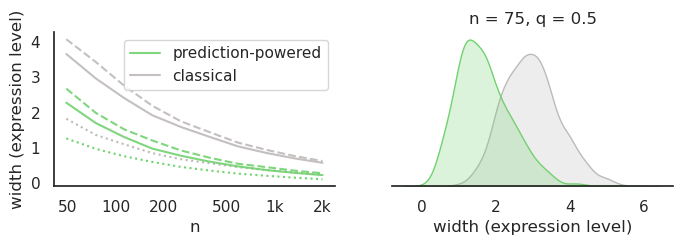

In [25]:
save = True
n_to_plot = 75
plot_df = df.loc[(df.q == 0.5) & (df.n == n_to_plot)]
c_cl, c_pp = "#BFB9B9", "#71D26F"
ns = np.logspace(np.log10(50), np.log10(2000), num=10, base=10).astype(int)
ns_xticks = [50, 100, 200, 500, 1000, 2000]
ns_xticklabels = [50, 100, 200, 500, '1k', '2k']

fig, axs = plt.subplots(1, 2, figsize=(8, 2))
for q, ls in zip([0.25, 0.5, 0.75], [':', '-', '--']):
    dfqn = df.loc[df.q == q]
    wcl_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'classical')].width.mean()for n in ns])
    wpp_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'prediction-powered')].width.mean()for n in ns])
    axs[0].plot(
        ns, wpp_n,
        label='prediction-powered' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_pp)
    axs[0].plot(
        ns, wcl_n,
        label='classical' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_cl)
    
axs[0].set_xscale('log')
axs[0].set_xticks(ns_xticks)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels(ns_xticklabels)
axs[0].set_xlabel('n');
axs[0].set_ylabel('width (expression level)')
axs[0].legend();
sns.despine(ax=axs[0],top=True,right=True)

my_palette = sns.color_palette([c_pp, c_cl], 2)
sns.set_theme(style="white", palette=my_palette)
kde = sns.kdeplot(
    plot_df, x="width", hue="estimator", hue_order=["prediction-powered", "classical"],
    fill=True, ax=axs[1])
kde.get_legend().remove()
sns.despine(ax=axs[1],top=True,right=True,left=True)
axs[1].set_xlabel("width (expression level)")
axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title('n = {}, q = 0.5'.format(n_to_plot));
if save:
    plt.savefig('figures/widths.png', dpi=300, bbox_inches='tight')
plt.show()